In [1]:
import numpy as np
import numpy.random as rand

import ufl
from dolfinx import fem, io, mesh, plot
from ufl import ds, dx, grad, inner
from mpi4py import MPI
from petsc4py.PETSc import ScalarType

In [2]:
def harris_dP_dA(B, d, y):
    """
    Calculates the RHS of the grad-shafranov eqn for a harris current sheet.
    
    Parameters:
    -----------
    
    B : array-like of floats
        The characteristic magnetic field. Non-constant for perturbed harris
    d : array-like of floats
        characteristic thickness of the magnetic field, varies for perturbed harris
    y : array-like of floats
        distance from y=0 line. Varies for perturbed harris.
        
    Returns:
    --------
    dP_dA: RHS of grad-shafranov for perturbed harris sheet.
    """
    
    dP_dA = -1*B/d*ufl.cosh(y/d)**(-2)
    return dP_dA

In [3]:
class FourierRand():
    """
    For fourier series with random coefficients. form a0/2 + sum_1^n(aj*cos(2*pi*j*x/L + phij))
    Uses ufl cosine and is therefore annoying
    
    Parameters:
    -----------
    L : float
        The size of the box (one period of the Fourier series)
    n : integer
        The number of terms desired in the fourier series, not counting the zero term.
    an_fn : function, default rand.default_rng().normal
        an_fn(**kwargs) the random number generator desired to generate an coordinates
    phin_fn : function, default rand.default_rng().uniform
        phin_fn(**phin_kwargs) the random number generator desired to generate phin
    an_kws : dict, default self.default_an_kws
        default keywords for the an random generator
    phin_kws : dict, default self.default_phin_kws
        default keywords for the an random generator
    
    Attributes:
    -----------
    default_an_kws : dict
        class attribute default keywords for an_fn
    default_phin_kws " dict
        class attribute default keywords for phin_fn

    """
    default_an_kws = {'loc':0.0, 'scale':0.1}  #size is forcibly set during init
    default_phin_kws = {'low':0.0, 'high': 2*np.pi}
    
    def __init__(self, L, n, an_fn=rand.default_rng().normal, phin_fn = rand.default_rng().uniform, 
                 an_kws=default_an_kws, phin_kws=default_phin_kws):
        self.L = L
        self.n = n
        if an_fn is not None and phin_fn is not None:
            self.an_kws = self.default_an_kws | an_kws | {'size':n+1}
            self.phin_kws = self.default_phin_kws | phin_kws | {'size':n}
            ''' set an and phin, ensuring the correct size for each '''
            self.an = an_fn(**self.an_kws)
            self.phin = phin_fn(**self.phin_kws)
        else:
            raise NotImplementedError("Fourier series with predetermined coefficients is not implemented yet.")
    
    def __call__(self, x):
        """ return the fourier series for a value or series of values
        
        Parameters:
        -----------
        x : float or array-like of floats
            the point(s) to evaluate the fourier series at
            
        Returns:
        --------
        frand : float or array-like of floats
            same shape as x. fourier series evaluated at x.
        """
        frand = self.an[0]/2
        
        for i, phij in enumerate(self.phin):
            j=i+1  # in the math phin starts with index 1
            frand += self.an[j]*ufl.cos(2*np.pi*j*x/self.L - phij)
        
        return frand


In [4]:
bdy_bleft = (-10.0, -5.0)
bdy_tright = (10.0, 5.0)
d_0 = 1  # current sheet thickness
B_0 = 1  # magnetic field strength
nsquares = (256, 128)

In [5]:
msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=(bdy_bleft, bdy_tright), n=nsquares,
                            cell_type=mesh.CellType.triangle,)

V = fem.FunctionSpace(msh, ("Lagrange", 1))

In [6]:
def bdy_finder_generator(bdy_bleft, bdy_tright):
    """ generator function so bdy_finder depends only on x"""
    def bdy_finder(x):
       
        bdy = np.any([np.isclose(x[0], bdy_bleft[0]),
                            np.isclose(x[0], bdy_tright[0]),
                            np.isclose(x[1], bdy_bleft[1]),
                            np.isclose(x[1], bdy_tright[1])], axis=0)
        return bdy
    return bdy_finder

facets = mesh.locate_entities_boundary(msh, dim=1,
                                       marker=bdy_finder_generator(bdy_bleft, bdy_tright))

In [7]:
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

In [8]:
def harris_bc_gen(d_0):
    """Makes function to determine dirichlet boundary conditions for harris sheet """
    def harris_bc(x):
        bdy_val = d_0*B_0*np.log(np.cosh(x[1]/d_0))
        return bdy_val
    return harris_bc

bd_fn = harris_bc_gen(d_0)
har_bc = fem.Function(V, dtype=ScalarType)
har_bc.interpolate(bd_fn)


bc = fem.dirichletbc(value=har_bc, dofs=dofs)

### possible functions

In [9]:
y_curvy_func = lambda x: x[1] + ufl.cos(x[0])  # x[0], x[1]  the two dimensions
d_var_x = lambda x: d_0 + .2*d_0*(.6*ufl.sin(.935*x[0]+.5134)+.8*ufl.cos(.572*x[0]+2.11))  # make sure this doesn't go negative lol
b_var_x = lambda x: B_0 + .3*B_0*x[0]/bdy_tright[0]*ufl.sin(1.3*x[0])
b_var_y = lambda x: B_0 + B_0*ufl.sin(2*x[1]*x[0])*(x[0] - bdy_bleft[0])*(x[0] - bdy_tright[0])/abs(bdy_bleft[0]*bdy_tright[0])

messy_fn = FourierRand(bdy_tright[0]-bdy_bleft[0], 15)
y_noisy = lambda x: x[1] + messy_fn(x[0])



In [10]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)

param_sets = [[B_0, d_0, x[1]],
              [B_0, d_0, y_curvy_func(x)],
              [B_0, d_var_x(x), x[1]],
              [b_var_x(x), d_0, x[1]],
              [b_var_y(x), d_0, x[1]],
              [B_0, d_0, y_noisy(x)]]
solns=[]  # set of solutions

In [11]:
for param_set in param_sets:
    b,d,y = param_set  #unpack params for readability
    f = harris_dP_dA(b, d, y)  # defined as laplace A = -f
    a = inner(grad(u), grad(v)) * dx
    L = inner(f, v) * dx 
    problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    solns.append(problem.solve())

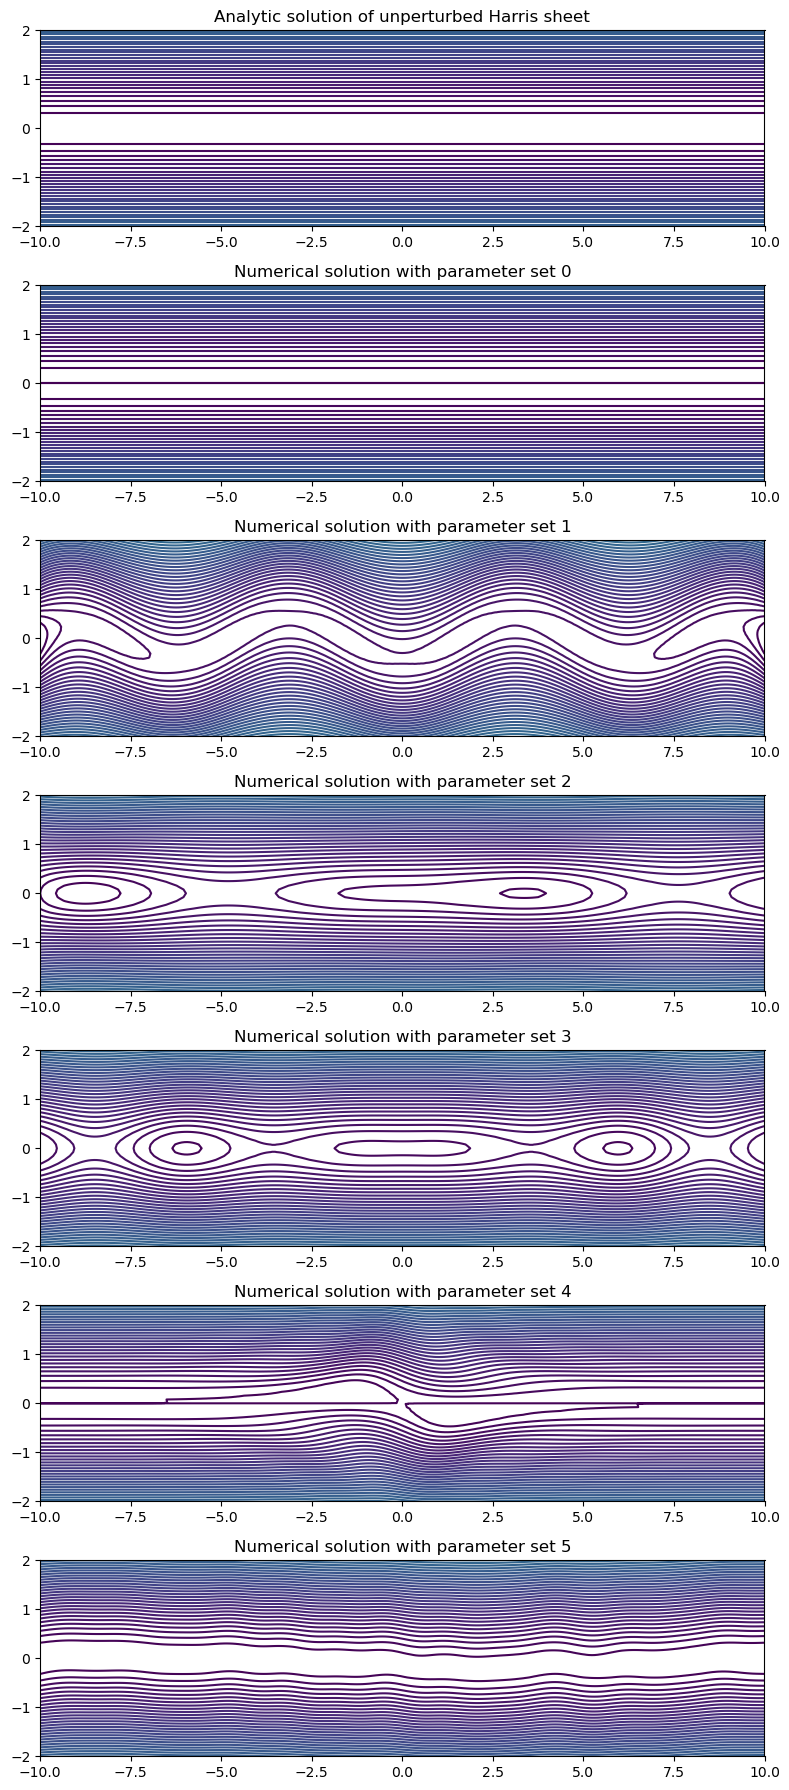

In [12]:
import matplotlib.pyplot as plt

num_plots = len(param_sets)+1
fig,ax = plt.subplots(num_plots, figsize=(8,18))
levels = 100

ax[0].tricontour(msh.geometry.x[:,0], msh.geometry.x[:,1], d_0*B_0*np.log(np.cosh(msh.geometry.x[:,1]/d_0)), levels=levels)
ax[0].set_title("Analytic solution of unperturbed Harris sheet")
ax[0].set_ylim(-2,2)

for i in range(len(param_sets)):
    ax[i+1].tricontour(msh.geometry.x[:,0], msh.geometry.x[:,1], solns[i].x.array.real, levels=levels)
    ax[i+1].set_title(f"Numerical solution with parameter set {i}")
    ax[i+1].set_ylim(-2,2)

fig.tight_layout()
plt.show()

The solution with dP/dA significantly asymmetric in y is funky, everything else looks qualitatively good

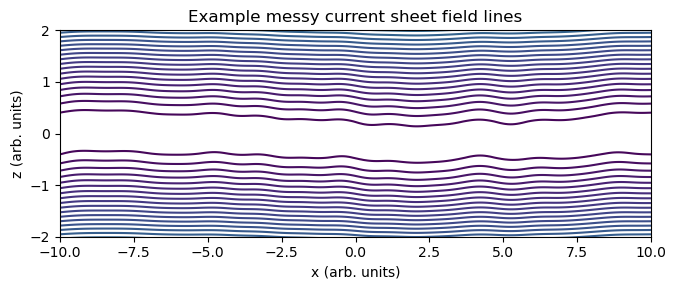

In [13]:

fig,ax = plt.subplots(figsize=(7,3))
levels = 70

ax.tricontour(msh.geometry.x[:,0], msh.geometry.x[:,1], solns[i].x.array.real, levels=levels)
ax.set(title='Example messy current sheet field lines', xlabel='x (arb. units)', ylabel='z (arb. units)')
ax.set_ylim(-2,2)

fig.tight_layout()
plt.show()

In [15]:
fig.savefig("out_poisson/messy_sheet.pdf")